In [14]:
import matplotlib
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
from torch.optim import lr_scheduler

from torchmetrics import Accuracy

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os
import json

# Image manipulations
from PIL import Image
# Useful for examining network
# from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams['font.size'] = 14

#custom class
from dataset import MyDataset
from slowfastnet import SlowFast,Bottleneck
from TrainTestCode import train

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'




In [2]:

# functions
def getClassDict(jsonfile):
    with open(jsonfile) as json_file:
        data = json.load(json_file)

        return data

def mapIntToClass(prediction,classjson):
    class_dict = getClassDict(classjson)
    keys_labels = list(class_dict.keys())
    values_int = list(class_dict.values())
    position = values_int.index(prediction)
    label = keys_labels[position]

    return label

def mapPrection2Class(y):
    class_dict = getClassDict("HACS_clips_v1.1__val_dictionary.json")
    vals = class_dict[y]
    path_label = vals[2]
    label = path_label.split("/")[6]

    return label

class UnNormalize(object):
    def __init__(self,mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
def show_img():
    pass

def predict(dataLoader, model, jsonfile):

    model.eval()

    for batch_ind, batch in enumerate(dataLoader):
        # batch = batch.cuda()
        img, actual_y = batch
        y =  model(img)
        #top 5: print top-5 predictions
        post_act = torch.nn.Softmax(dim=1)
        preds = post_act(y)
        pred_classes = preds.topk(k=5).indices[0]
        # print(preds)
        pred_class_names = []#[mapPrection2Class(str(i)) for i in pred_classes]
        pred_probabilities = []
        for indx,i in enumerate(pred_classes):
            i = i.detach().numpy()
            pred_class_names.append(mapIntToClass(int(i),jsonfile))
            probs = preds[0][pred_classes[indx]]
            # print(probs.item())
            pred_probabilities.append(probs.item())

        actual_y = actual_y.detach().numpy()
        actual_y = mapIntToClass(int(actual_y[0]),jsonfile)

        # Convert results to dataframe for plotting
        result = pd.DataFrame({'p': pred_probabilities}, index=pred_class_names)
        print(result)
        #plot
        unnormalize = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        plt.figure(figsize=(16, 5))
        ax = plt.subplot(1, 2, 1)
        mid_val = int(len(img)/2)
        plt.interactive(True)
        print(img.shape)
        ax.set_title(actual_y, size=20)
        for img_ in img[0].permute(1, 0, 2, 3):
            print(img_.shape)
            img_ = unnormalize(img_)
            img_ = img_.permute(1, 2, 0)
            img_ = img_.numpy()
            # ax, img = imshow_tensor(img_, ax=ax)
            plt.imshow((img_ * 255).astype(np.uint8))
            plt.show()

#         ax.set_title(actual_y, size=20)
#         # Plot a bar plot of predictions
#         result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
#         plt.xlabel('Predicted Probability')
#         plt.tight_layout()
#         plt.show()


In [3]:
#Load model
#initialize
# model_ = SlowFast(Bottleneck, [3, 4, 6, 3],num_classes=21)

# #load pre-tained parameter
# state_dict = torch.load('/Users/feyisayoolalere/Downloads/model_save/curious-firefly-53_adults.pt',map_location=torch.device('cpu'))
# model_.load_state_dict(state_dict,strict=False)
# model_.eval()

state_dict = torch.load(config['checkpoint_path'],map_location=device)#remove map_location on Gpu
model.fc =  nn.Linear(num_ftrs, 21)
model.load_state_dict(state_dict)
model.epoch = 0




_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.bias'])

SlowFast(
  (fast_conv1): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
  (fast_bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fast_relu): ReLU(inplace=True)
  (fast_maxpool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
  (fast_res2): Sequential(
    (0): Bottleneck(
      (conv1): Conv3d(8, 8, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(8, 8, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (bn2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
     

                                 p
playing badminton_adult   0.844446
playing volleyball_adult  0.082415
playing basketball_adult  0.021081
playing tennis_adult      0.018843
dunking basketball_adult  0.016023
torch.Size([1, 3, 75, 256, 256])
torch.Size([3, 256, 256])


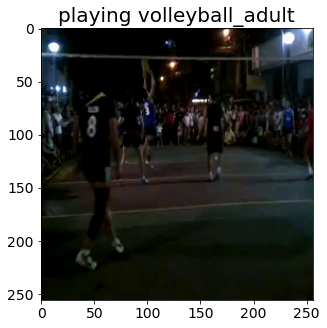

torch.Size([3, 256, 256])


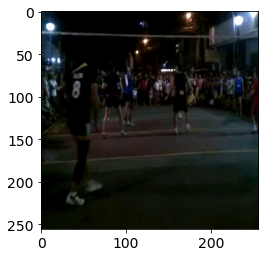

torch.Size([3, 256, 256])


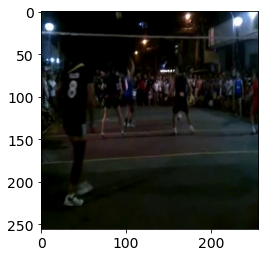

torch.Size([3, 256, 256])


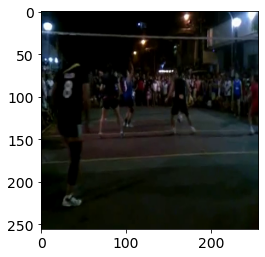

torch.Size([3, 256, 256])


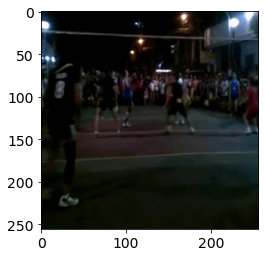

torch.Size([3, 256, 256])


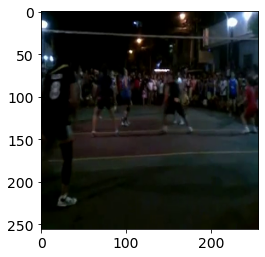

torch.Size([3, 256, 256])


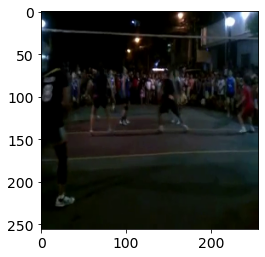

torch.Size([3, 256, 256])


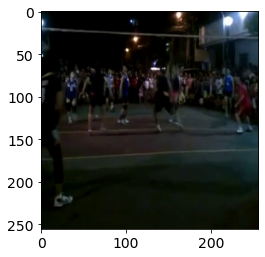

torch.Size([3, 256, 256])


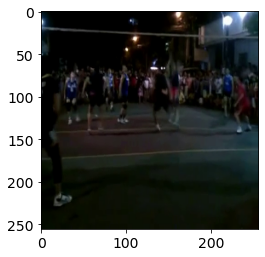

torch.Size([3, 256, 256])


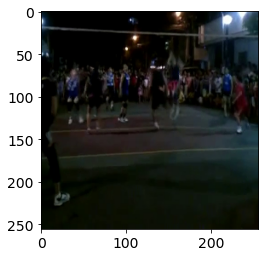

torch.Size([3, 256, 256])


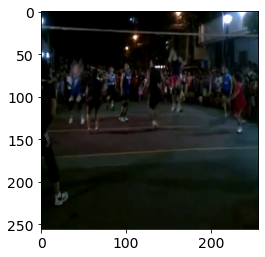

torch.Size([3, 256, 256])


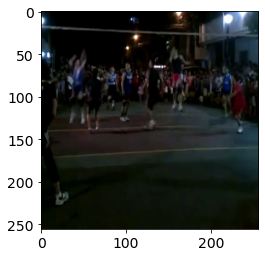

torch.Size([3, 256, 256])


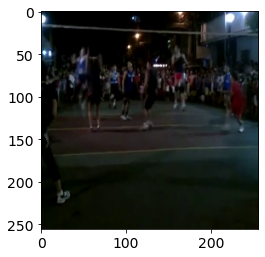

torch.Size([3, 256, 256])


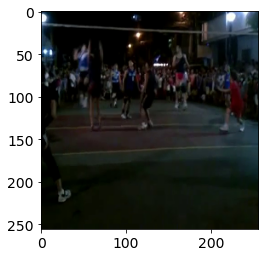

torch.Size([3, 256, 256])


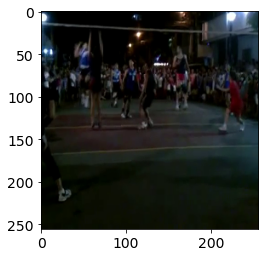

torch.Size([3, 256, 256])


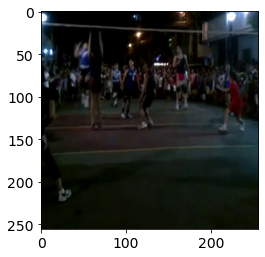

torch.Size([3, 256, 256])


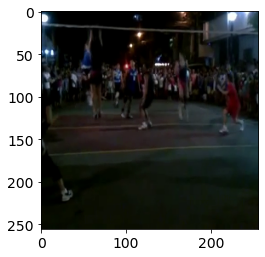

torch.Size([3, 256, 256])


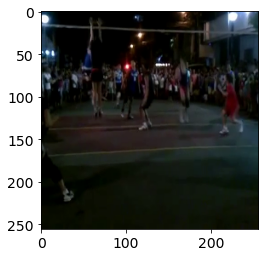

torch.Size([3, 256, 256])


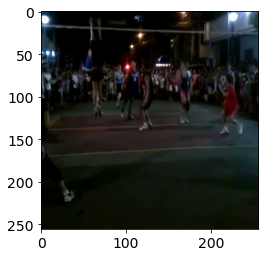

torch.Size([3, 256, 256])


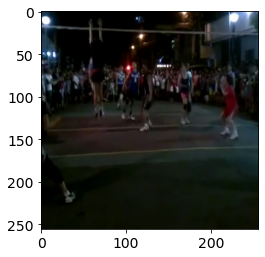

torch.Size([3, 256, 256])


KeyboardInterrupt: 

In [5]:
#test adult_finetuned model
adult_test = MyDataset("Data_Csv/TestSplit-adults.csv","className_AdultTest.json",mode='test')
test_dataloader_adult = DataLoader(adult_test,batch_size= 1,shuffle=True)


predict(test_dataloader_adult, model_, "className_AdultTest.json")

In [18]:
# #test HACS
# hacs_test = MyDataset("/Users/feyisayoolalere/Downloads/HacsSampleTest.csv","className_HacsTest.json",mode='val')
# test_dataloader_hacs = DataLoader(hacs_test,batch_size= 1,shuffle=True)


# predict(test_dataloader_hacs, model, "className_HacsTest.json")




In [40]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
#     model.train()

In [41]:
check_accuracy(test_dataloader_adult, model_)


Got 316 / 643 with accuracy 49.14


In [93]:
def getTop_k(test_loader,model):
    model.eval()
    top1 = []
    top5 = []
    accuracy1 = Accuracy(top_k=1)
    accuracy5 = Accuracy(top_k=5
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            # measure data loading time
#             print(f"Processing {batch_idx+1}/{len(test_loader)}")
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

            # compute output
            outputs = model(inputs)
            accuracy1(outputs, targets)
            accuracy5(outputs, targets)

    return accuracy1.compute(),accuracy5.compute()

In [94]:
top1,top5 = getTop_k(test_dataloader_adult,model)



In [96]:
top5

tensor(0.8000)

# create confusion matrix

In [43]:
"""so if the model is kids specific: we calculate accuracy on kids test split and
also top1 and top5 on this split but we draw a confusion matrix on the adults test split.

When its adult specific model we repeat the process.
"""



'so if the model is kids specific: we calculate accuracy on kids test split and\nalso top1 and top5 on this split but we draw a confusion matrix on the adults test split.\n\nWhen its adult specific model we repeat the process.\n'

In [102]:
def getConfusionMatrix(dataLoader,model):
    nb_classes = 21
    model.eval()
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataLoader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1 
    return confusion_matrix
                    
                    
    

In [103]:
confusion_matrix = getConfusionMatrix(test_dataloader_adult,model)


In [107]:
#read labels
f = open("className_AdultTest.json",)
labels = json.load(f)
labels

{'archery_adult': 0,
 'bouncing on trampoline_adult': 1,
 'bowling_adult': 2,
 'cartwheeling_adult': 3,
 'catching or throwing baseball_adult': 4,
 'catching or throwing frisbee_adult': 5,
 'catching or throwing softball_adult': 6,
 'dribbling basketball_adult': 7,
 'dunking basketball_adult': 8,
 'hitting baseball_adult': 9,
 'juggling soccer ball_adult': 10,
 'kicking soccer ball_adult': 11,
 'parkour_adult': 12,
 'playing badminton_adult': 13,
 'playing basketball_adult': 14,
 'playing cricket_adult': 15,
 'playing tennis_adult': 16,
 'playing volleyball_adult': 17,
 'shooting basketball_adult': 18,
 'somersaulting_adult': 19,
 'water skiing_adult': 20}

<Figure size 1080x720 with 0 Axes>

[Text(0, 0.5, 'archery_adult'),
 Text(0, 1.5, 'bouncing on trampoline_adult'),
 Text(0, 2.5, 'bowling_adult'),
 Text(0, 3.5, 'cartwheeling_adult'),
 Text(0, 4.5, 'catching or throwing baseball_adult'),
 Text(0, 5.5, 'catching or throwing frisbee_adult'),
 Text(0, 6.5, 'catching or throwing softball_adult'),
 Text(0, 7.5, 'dribbling basketball_adult'),
 Text(0, 8.5, 'dunking basketball_adult'),
 Text(0, 9.5, 'hitting baseball_adult'),
 Text(0, 10.5, 'juggling soccer ball_adult'),
 Text(0, 11.5, 'kicking soccer ball_adult'),
 Text(0, 12.5, 'parkour_adult'),
 Text(0, 13.5, 'playing badminton_adult'),
 Text(0, 14.5, 'playing basketball_adult'),
 Text(0, 15.5, 'playing cricket_adult'),
 Text(0, 16.5, 'playing tennis_adult'),
 Text(0, 17.5, 'playing volleyball_adult'),
 Text(0, 18.5, 'shooting basketball_adult'),
 Text(0, 19.5, 'somersaulting_adult'),
 Text(0, 20.5, 'water skiing_adult')]

[Text(0.5, 0, 'archery_adult'),
 Text(1.5, 0, 'bouncing on trampoline_adult'),
 Text(2.5, 0, 'bowling_adult'),
 Text(3.5, 0, 'cartwheeling_adult'),
 Text(4.5, 0, 'catching or throwing baseball_adult'),
 Text(5.5, 0, 'catching or throwing frisbee_adult'),
 Text(6.5, 0, 'catching or throwing softball_adult'),
 Text(7.5, 0, 'dribbling basketball_adult'),
 Text(8.5, 0, 'dunking basketball_adult'),
 Text(9.5, 0, 'hitting baseball_adult'),
 Text(10.5, 0, 'juggling soccer ball_adult'),
 Text(11.5, 0, 'kicking soccer ball_adult'),
 Text(12.5, 0, 'parkour_adult'),
 Text(13.5, 0, 'playing badminton_adult'),
 Text(14.5, 0, 'playing basketball_adult'),
 Text(15.5, 0, 'playing cricket_adult'),
 Text(16.5, 0, 'playing tennis_adult'),
 Text(17.5, 0, 'playing volleyball_adult'),
 Text(18.5, 0, 'shooting basketball_adult'),
 Text(19.5, 0, 'somersaulting_adult'),
 Text(20.5, 0, 'water skiing_adult')]

Text(109.85937499999999, 0.5, 'True label')

Text(0.5, 64.859375, 'Predicted label')

''

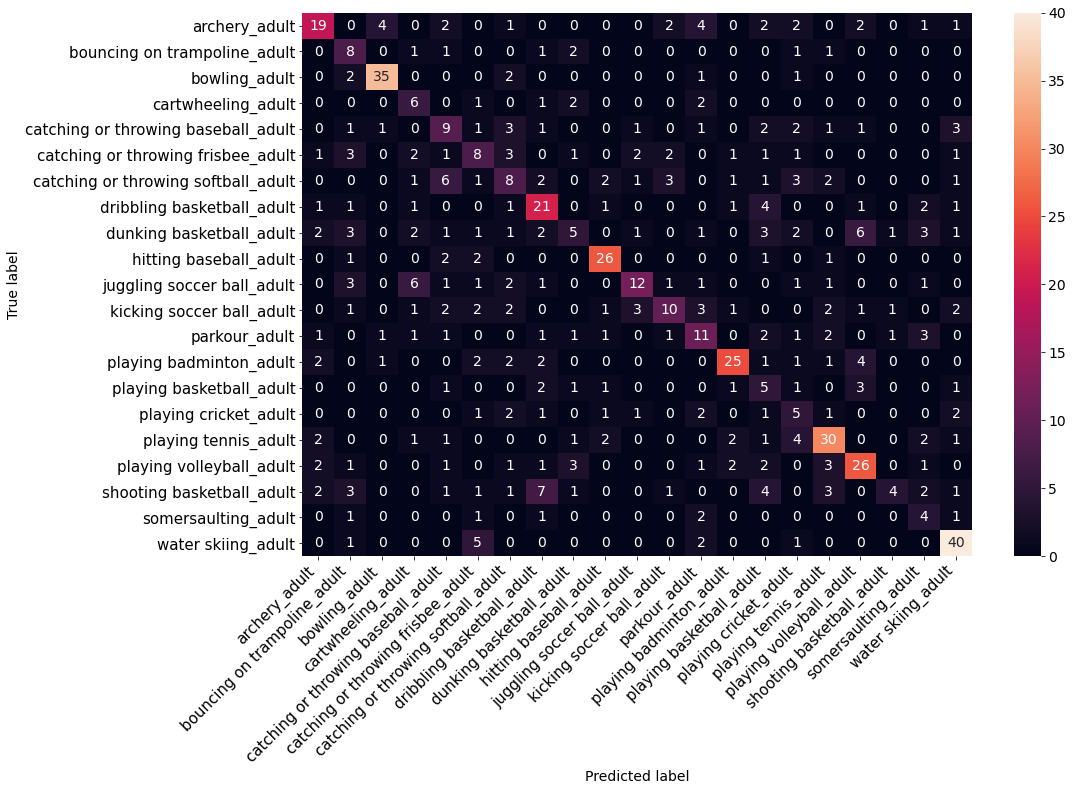

In [108]:
#to plot
plt.figure(figsize=(15,10))

class_names = list(labels.keys())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

# GET ACCURACY PER CLASS

In [113]:
#To get the per-class accuracy:
acc_per_class = (confusion_matrix.diag()/confusion_matrix.sum(1))
acc_per_class = acc_per_class.tolist()
df_acc_per_class = pd.DataFrame({"Class":labels.keys(),"Accuracy":acc_per_class})
# print(confusion_matrix.diag()/confusion_matrix.sum(1))

In [114]:
df_acc_per_class

,Class,Accuracy
0,archery_adult,0.475000
1,bouncing on trampoline_adult,0.533333
2,bowling_adult,0.853659
3,cartwheeling_adult,0.500000
4,catching or throwing baseball_adult,0.333333
5,catching or throwing frisbee_adult,0.296296
6,catching or throwing softball_adult,0.250000
7,dribbling basketball_adult,0.600000
8,dunking basketball_adult,0.142857
9,hitting baseball_adult,0.787879
